Each label is encoded, 0-9, representing a class. Each image is a 3072 length array. The images are 32x32, so the first 1024 values correspond to the red channel, followed by the green and the red.

In [1]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [2]:
data = unpickle('cifar-10-batches-py/data_batch_1')

In [3]:
x = data[b'labels']
y = data[b'data']

In [4]:
data.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

# asdfadfasfas

In [14]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from skimage import io, transform
from torchvision import utils, transforms
import random

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
import warnings
warnings.filterwarnings('ignore')

# Image Preprocessing Functions

In [7]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        
        h, w = image.shape[:2]
#         h, w = 32, 32
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        
        new_h, new_w = int(new_h), int(new_w)
        img = transform.resize(image, (new_h, new_w))
               
        return {'image': img, 'label': label}
    

class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
            
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        
        top = np.random.randint(0, h-new_h)
        left = np.random.randint(0, w-new_w)
        
        image = image[top: top+new_h,
                      left: left+new_w]
        
        return {'image': image, 'label': label}
    
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        
        # swap color axis because
        # numpy iamge: HxWxC
        # torch image: CxHxW
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'label': label}

# Create the Dataset Object

In [32]:
class CIFARDataset(Dataset):
    def __init__(self, batch_lst:list, transform=None):
        """To be used when iterating over the 
        files within the root directory"""
        self.labels, self.images = [], []
        
        for file in batch_lst:
            data = unpickle(file)
            self.labels += data[b'labels']
            self.images += [cifar10_to_rgb(img) for img in data[b'data']]
#         self.images = cifar10_to_rgb(data[b'data'])
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx:int) -> dict:
        """For any index in the range of img_lst
        it maps image to the image values
        and species to the type of bird"""
        sample = {'image': self.images[idx], 
                  'label': self.labels[idx]}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

In [33]:
def cifar10_to_rgb(arr_lst):
    ___ = []
    for k in range(32):
        __ = []
        for j in range(32):
            _ = []
            for i in range(3):
                _ += [arr_lst[1024*i+32*j+k]]
            __ += [_]
        ___ += [__]
    return np.array(___)

In [34]:
batch_lst = """cifar-10-batches-py/data_batch_1
               cifar-10-batches-py/data_batch_2
               cifar-10-batches-py/data_batch_3
               cifar-10-batches-py/data_batch_4
               cifar-10-batches-py/data_batch_5
            """.split()

CIFAR = CIFARDataset(batch_lst,
                     transform=transforms.Compose([
#                                       Rescale(256),
                                      RandomCrop(30),
                                      ToTensor()
                                  ]))

In [35]:
train_dataset, test_dataset = train_test_split(CIFAR, random_state=88)

In [ ]:
# upload_root_dir = Path('uploaded_img/')
# upload_img_lst = os.listdir('uploaded_img/')
# # upload_birds_dataset = BirdDataset(upload_root_dir, upload_img_lst)

# upload_bird_dataset = BirdDataset(upload_root_dir, upload_img_lst,
#                                   transform=transforms.Compose([
#                                       Rescale(256),
#                                       RandomCrop(224),
#                                       ToTensor()
#                                   ]))

In [ ]:
# predictions = net(upload_tensor.reshape((1, 3, 224, 224)))

In [ ]:
# predictions = predictions.tolist()[0]

In [ ]:
# predictions.index(max(predictions))

In [ ]:
# predictions[96]

6
torch.Size([3, 30, 30])
1
torch.Size([3, 30, 30])
3
torch.Size([3, 30, 30])
5
torch.Size([3, 30, 30])


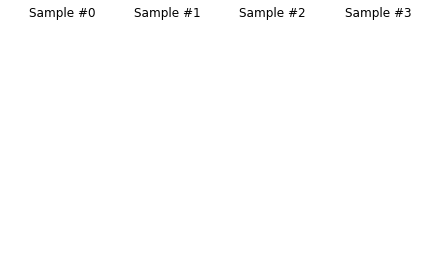

In [38]:
def show_img(image):
    plt.imshow(image)
    plt.pause(0.001)
    

fig = plt.figure()

for i in range(len(train_dataset)):
    sample = train_dataset[i]
    
    print(sample['label'])
    print(sample['image'].shape)
    
    ax = plt.subplot(1, 4, i+1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
#     show_duck(sample['image'])
#     show_img(sample['image'])
    
    if i == 3:
        plt.show()
        break

# Use the Data Loader to Implement Batches

In [39]:
# train_birds_dataset = BirdDataset(train_root_dir, train_img_lst,
#                                   transform=transforms.Compose([
#                                                 Rescale(256),
#                                                 RandomCrop(224),
#                                                 ToTensor()
#                                   ]))
# test_birds_dataset = BirdDataset(test_root_dir, test_img_lst,
#                                  transform=transforms.Compose([
#                                                  Rescale(256),
#                                                  RandomCrop(224),
#                                                  ToTensor()
#                                  ]))

In [40]:
train_dataloader = DataLoader(train_dataset, batch_size=4,
                              shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=4,
                             shuffle=True, num_workers=4)

In [ ]:
# train_dataloader = DataLoader(train_birds_dataset, batch_size=4,
#                               shuffle=True, num_workers=4)
# test_dataloader = DataLoader(test_birds_dataset, batch_size=4,
#                               shuffle=True, num_workers=4)
 
# def show_birds_batch(sample_batched):
#     """Show species images for a batch"""
#     images_batch, species_batch = sample_batched['image'], sample_batched['species']
#     batch_size = len(images_batch)
#     im_size = images_batch.size(2)
    
#     grid = utils.make_grid(images_batch)
#     plt.imshow(grid.numpy().transpose((1, 2, 0)))
    
#     for i in range(batch_size):      
#         plt.title('Batch from dataloader')
    
    
# for i_batch, sample_batched in enumerate(train_dataloader):
#     print(i_batch, sample_batched['image'].size(),
#           sample_batched['species'])
#     plt.figure()
#     show_birds_batch(sample_batched)
#     plt.axis('off')
#     plt.ioff()
#     plt.show()
    
#     if i_batch == 3:
#         break

# Train The Model

### Define The Network

In [45]:
class Network(nn.Module):
    def __init__(self, dropout_rate=0):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 8)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 10, 8)
        self.fc1 = nn.Linear(10*2*2, 1000)
        self.fc2 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(100, 10)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        print(x.shape)
        
        x = x.view(-1, 10*2*2)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
    
net = Network()

In [46]:
net.train()
running_loss = 0.0
for i, data in enumerate(train_dataloader, 0):
    inputs = data['image'].float()
    outputs = net(inputs)
    print(outputs)

torch.Size([4, 10, 2, 2])
tensor([[-1.4259,  0.1217,  0.5492, -0.6552,  1.4679, -0.9835, -0.1307,  1.2061,
         -0.0932,  1.2314],
        [-1.4312,  0.8459, -0.2013, -0.9162,  1.6328, -0.8453,  0.0342,  1.1156,
          0.1312,  2.9601],
        [-2.9445,  0.8556, -0.5196, -0.7096,  2.6284, -0.4118,  0.0180,  0.7758,
         -0.4291,  3.2401],
        [-0.6927,  0.7449, -0.0468, -0.8854,  2.4325, -1.2416,  0.4111,  1.9570,
          0.5251,  1.9899]], grad_fn=<ThAddmmBackward>)
torch.Size([4, 10, 2, 2])
tensor([[-2.1322,  0.6464,  1.0398, -0.8869,  1.9658, -1.7554,  1.1728,  1.2682,
          0.7840,  2.4846],
        [-0.9994,  0.4869,  0.2219, -0.8025,  2.3015, -0.8884,  0.8491,  1.6452,
          0.3708,  0.6668],
        [-1.7595,  0.8014, -0.1393, -0.8241,  1.8294, -1.0683, -0.3375,  1.4878,
          0.0789,  2.3994],
        [-1.1239,  0.5106,  0.4960, -0.5433,  1.7308, -0.7716,  0.2415,  0.9675,
         -0.1632,  1.2418]], grad_fn=<ThAddmmBackward>)
torch.Size([4, 10, 2

torch.Size([4, 10, 2, 2])
tensor([[-2.8769, -0.4022,  1.1176, -1.4034,  2.3718, -1.1361,  0.1652, -0.0517,
         -0.4962,  2.2869],
        [-1.7651,  0.2685,  0.5992, -1.5544,  3.0684, -2.0279,  0.8199,  1.9914,
         -0.1438,  2.3954],
        [-2.7861,  0.5888, -0.0586, -0.7548,  2.5621, -0.6022,  0.2340,  0.3747,
          0.4326,  2.1653],
        [-3.9899,  2.2228, -0.8010, -1.4257,  3.8663, -0.9947, -1.6523,  1.9200,
         -0.0133,  5.6058]], grad_fn=<ThAddmmBackward>)
torch.Size([4, 10, 2, 2])
tensor([[-2.0863, -0.4743,  0.2862, -0.6795,  2.6774, -1.4572,  1.1321,  1.0298,
         -0.4629,  2.6823],
        [-1.5007,  0.1467, -0.1797, -0.8936,  1.6223, -1.0918, -0.0575,  1.0915,
         -0.4526,  2.6295],
        [-3.6485,  0.5969,  0.5018, -1.0543,  3.3264, -1.9997,  0.1115,  1.0906,
         -0.6209,  4.5613],
        [-0.9870,  0.6194,  0.0151, -0.2369,  2.3731, -0.1685, -0.0674,  0.0712,
          1.3928,  0.6320]], grad_fn=<ThAddmmBackward>)
torch.Size([4, 10, 2

torch.Size([4, 10, 2, 2])
tensor([[-2.2219,  0.0282,  0.4235, -1.5800,  1.9848, -2.0284,  0.7180,  1.0193,
         -0.1275,  2.1277],
        [-2.0747, -0.2075,  0.4115, -0.8768,  1.8659, -2.0289,  0.5832,  1.5089,
         -0.6061,  4.0302],
        [-3.2895,  0.0067,  0.6360, -1.7200,  3.0574, -2.3615,  0.6128,  1.5320,
         -0.2438,  3.5937],
        [-2.1750,  0.8994,  0.0096, -0.8857,  2.5644, -2.3969,  0.0172,  1.7582,
         -0.2564,  3.5706]], grad_fn=<ThAddmmBackward>)
torch.Size([4, 10, 2, 2])
tensor([[-1.7786, -0.0408,  0.6196, -1.1061,  1.5367, -1.4842,  0.2606,  0.7555,
         -0.5063,  2.1675],
        [-1.3594,  0.7187, -0.0081, -0.4436,  3.2644, -0.8596,  0.9692,  1.2585,
          1.0311,  1.3225],
        [-2.2736,  0.1934,  0.1840, -1.3055,  2.8045, -1.6906,  0.9567,  1.2409,
         -0.0248,  2.1429],
        [-2.2290,  0.5085, -0.1696, -0.5920,  1.6883, -1.1774,  0.3967,  1.0938,
         -0.5360,  3.2272]], grad_fn=<ThAddmmBackward>)
torch.Size([4, 10, 2

torch.Size([4, 10, 2, 2])
tensor([[-1.7599,  0.7194,  0.4063, -1.5308,  2.4848, -1.2794,  0.6116,  1.3102,
         -0.3078,  2.0177],
        [-1.2988,  1.1924, -0.2148, -0.9907,  3.2502, -1.8755,  0.3502,  2.2953,
          0.2095,  3.1571],
        [-3.1033, -0.2945,  0.3831, -0.7781,  3.0717, -1.2596,  1.0697,  0.6001,
         -0.0149,  2.2139],
        [-1.3771, -0.3832, -0.0891, -0.4203,  1.4311, -1.2389,  0.6731,  1.0871,
         -0.4336,  2.1677]], grad_fn=<ThAddmmBackward>)
torch.Size([4, 10, 2, 2])
tensor([[-2.4168,  0.0769,  0.6993, -1.2606,  2.8434, -2.3238,  0.6012,  2.2379,
         -0.6072,  3.1008],
        [-1.1241,  0.2058,  0.2364, -1.1411,  1.7078, -1.6412,  0.4452,  1.7379,
         -0.6721,  2.2404],
        [-1.7492,  0.1337,  0.1808, -1.0455,  1.7186, -1.7293,  0.3716,  1.9073,
         -0.4646,  3.8494],
        [-3.2152, -0.1085,  0.1493, -1.3622,  2.3346, -1.6325,  0.9700,  1.1308,
         -0.1266,  3.4987]], grad_fn=<ThAddmmBackward>)
torch.Size([4, 10, 2

tensor([[-1.2139,  0.2261, -0.1765, -0.7958,  1.6868, -0.2204,  0.5728,  0.0009,
         -0.0748,  1.1669],
        [-2.0633,  0.8377, -0.0995, -1.2287,  2.9295, -1.2719,  0.2701,  1.0643,
         -0.1312,  2.9413],
        [-2.2534,  1.3746,  0.7132, -1.4740,  2.9295, -1.2233,  0.3476,  0.7413,
          0.6938,  3.5932],
        [-2.5316,  0.3207,  0.1363, -1.6868,  2.4593, -2.1523,  0.5997,  2.1600,
         -0.7591,  3.9616]], grad_fn=<ThAddmmBackward>)
torch.Size([4, 10, 2, 2])
tensor([[-0.9667,  0.0265, -0.1086, -0.6362,  2.2425, -1.4526,  0.9284,  2.1988,
          0.3658,  1.9246],
        [-1.2356,  0.7838, -0.3703,  0.5969,  2.9126, -0.5976,  0.0941, -0.4762,
          2.1925, -0.5136],
        [-2.8018,  0.2704,  0.2769, -0.8694,  3.6855, -2.1595,  0.7026,  2.0279,
         -0.0403,  3.8940],
        [-2.1823, -0.0250,  0.6302, -1.7183,  1.8563, -2.1134,  0.3616,  2.3544,
         -0.6166,  4.5369]], grad_fn=<ThAddmmBackward>)
torch.Size([4, 10, 2, 2])
tensor([[-2.1729,  0

torch.Size([4, 10, 2, 2])
tensor([[-1.3586,  0.8461,  0.0536, -1.0799,  2.9509, -0.8688,  0.9480,  1.0432,
          0.7957,  1.0532],
        [-1.0259,  0.1300,  0.5482, -0.3334,  1.4957, -0.7304,  0.3258,  0.7696,
         -0.2423,  1.4596],
        [-1.5597,  0.5624,  0.0408, -0.6129,  2.0733, -1.8674,  0.4340,  1.9413,
         -0.0058,  3.3136],
        [-1.8277, -0.2014,  0.5587, -0.4940,  1.5681, -1.7215,  0.6067,  1.2014,
         -0.5528,  2.7547]], grad_fn=<ThAddmmBackward>)
torch.Size([4, 10, 2, 2])
tensor([[-0.7084,  0.8303, -0.2325, -0.8723,  1.5633, -0.9357,  0.6836,  0.9605,
         -0.3095,  1.2290],
        [-1.4003, -0.0131,  0.7334, -1.0639,  2.3514, -1.5453,  0.6406,  1.7561,
         -0.0014,  2.1575],
        [-3.0828,  0.5131,  0.8816, -0.9543,  2.4986, -2.6629,  0.0568,  1.6191,
         -0.8406,  2.9465],
        [-1.4896,  0.0413,  0.4712, -0.9245,  2.5281, -2.0779,  0.7759,  2.3128,
          0.1337,  3.1441]], grad_fn=<ThAddmmBackward>)
torch.Size([4, 10, 2

tensor([[-1.2493,  0.4924, -0.3653, -0.1628,  1.3641, -1.2045,  0.2411,  1.0911,
          0.0655,  2.2086],
        [-3.1408,  0.8200, -0.5875, -0.7210,  2.3814, -0.3883,  0.4845, -0.0963,
         -0.3781,  1.8931],
        [-1.7805,  1.0316,  0.3402, -1.4910,  2.6700, -1.8511, -0.4133,  1.9210,
         -0.7602,  2.5331],
        [-2.0828,  0.2435,  0.1981, -0.8001,  1.8319, -1.3430,  0.0956,  1.0096,
         -0.5757,  2.8691]], grad_fn=<ThAddmmBackward>)
torch.Size([4, 10, 2, 2])
tensor([[-2.0185,  0.2980,  1.2218, -1.5153,  1.3081, -1.4817,  0.2978,  0.9932,
          0.0713,  2.3778],
        [-2.0179,  0.6495, -0.6339, -0.5379,  2.3595, -0.8525,  0.2375,  1.2919,
         -0.3348,  3.0168],
        [-1.9564,  0.7814, -0.2279, -0.9259,  2.7203, -0.9700,  0.3159,  1.1581,
          0.0084,  3.5929],
        [-2.7173,  1.1940,  0.1391, -0.8069,  1.2174, -0.7551, -0.3468,  0.3835,
         -0.1156,  3.8187]], grad_fn=<ThAddmmBackward>)
torch.Size([4, 10, 2, 2])
tensor([[-2.4952, -0

torch.Size([4, 10, 2, 2])
tensor([[-2.4447,  0.4619,  0.1864, -1.1299,  2.1140, -1.5793,  0.2586,  0.5264,
         -0.4567,  2.5856],
        [-3.1347,  0.9255,  0.0249, -0.7525,  2.9942, -2.3956, -0.1653,  1.2630,
         -0.3823,  5.5328],
        [-1.5134,  0.5469,  0.9617, -1.5692,  3.6323, -2.0527,  1.1393,  2.1400,
          0.3738,  3.8410],
        [-1.9093, -0.6340,  0.3858, -0.9424,  2.4557, -2.2669,  1.9447,  1.8219,
          0.2451,  2.6090]], grad_fn=<ThAddmmBackward>)
torch.Size([4, 10, 2, 2])
tensor([[-2.5296,  0.0622,  0.4947, -0.0044,  1.8096, -1.7196,  0.3473,  0.3510,
         -0.6613,  4.0428],
        [-1.5551,  0.2088,  0.1316, -1.1717,  2.4562, -1.8074,  0.6835,  1.9626,
          0.0070,  3.3375],
        [-1.8626,  0.5838,  0.3284, -1.1165,  2.4405, -1.5170,  0.5608,  1.6514,
          0.0616,  2.0501],
        [-1.9231,  0.5515,  0.5573, -0.3694,  2.1566, -1.7248,  0.2472,  1.1155,
         -0.5578,  2.8690]], grad_fn=<ThAddmmBackward>)
torch.Size([4, 10, 2

tensor([[-2.3527,  0.6233, -0.1070, -0.6542,  1.9060, -1.0255,  0.1254,  0.9495,
         -0.3474,  2.9292],
        [-1.3181,  0.1350,  0.2724, -1.1575,  1.8004, -1.4843,  0.3951,  1.6383,
         -0.3122,  2.9860],
        [-1.4212,  0.1200,  0.6359, -1.3692,  1.9237, -1.6829,  0.3464,  1.4793,
         -0.1423,  3.3637],
        [-2.8931,  0.3065,  0.2062, -1.0325,  3.4235, -2.3694,  0.6822,  2.2101,
          0.1258,  4.7056]], grad_fn=<ThAddmmBackward>)
torch.Size([4, 10, 2, 2])
tensor([[-2.7100, -0.4034, -1.1593, -1.0800,  3.6626, -0.6920,  1.2216,  0.0081,
         -0.2182,  1.0754],
        [-1.3435,  1.1678, -0.0432, -0.9096,  1.5152, -0.4339, -0.7492,  0.1719,
          0.8112,  1.6837],
        [-2.1744, -0.1995,  0.3843, -1.6409,  2.6921, -1.2685,  0.8250,  1.2323,
         -0.2753,  1.9655],
        [-1.6365,  0.1939,  0.3714, -0.9594,  2.5615, -1.7522,  0.7878,  2.1764,
          0.2668,  2.7155]], grad_fn=<ThAddmmBackward>)
torch.Size([4, 10, 2, 2])
tensor([[-1.4336,  0

torch.Size([4, 10, 2, 2])
tensor([[-1.7236,  0.3413,  0.3067, -0.3212,  2.9376, -2.2876,  0.8624,  1.7099,
         -0.1197,  2.8415],
        [-2.4094,  1.4835, -0.0526, -0.8533,  3.3085, -2.4575,  0.0855,  2.1603,
         -0.2240,  4.7694],
        [-2.0109, -0.1069,  0.5354, -1.1029,  3.2822, -3.1942,  1.9767,  2.6212,
         -0.1084,  3.5442],
        [-1.5546,  0.1439,  0.3423, -0.6799,  2.1407, -1.3948,  0.6115,  1.3718,
         -0.0721,  2.7925]], grad_fn=<ThAddmmBackward>)
torch.Size([4, 10, 2, 2])
tensor([[-0.9655,  0.4013,  0.1938, -0.2939,  1.4443, -0.9210,  0.3261,  0.6803,
         -0.1418,  1.7236],
        [-1.8398,  0.3873,  0.5816, -0.6835,  2.5882, -1.6956,  0.8618,  1.6561,
         -0.0882,  1.9845],
        [-1.8314,  0.3569,  0.0849, -0.5065,  2.3323, -1.7967,  0.6893,  1.7414,
         -0.1359,  3.4839],
        [-2.4391,  1.1091, -0.5753, -0.8788,  3.0095, -0.7777, -0.1002,  1.3701,
          0.0260,  3.6363]], grad_fn=<ThAddmmBackward>)
torch.Size([4, 10, 2

torch.Size([4, 10, 2, 2])
tensor([[-2.7799,  0.8419, -0.6632, -1.6048,  2.9290, -1.7814,  0.1422,  1.6974,
         -0.9563,  3.1908],
        [-1.7226,  1.0642,  0.1713, -1.8931,  2.0746, -1.1778,  0.4844,  1.1701,
          0.9139,  3.0154],
        [-2.1438, -0.2855,  0.1319, -0.9278,  2.2583, -1.3372,  1.2053,  0.9225,
         -0.1628,  1.9345],
        [-3.5346, -0.0315,  0.0072, -1.4468,  4.2412, -1.8726,  1.0663,  1.0587,
          0.2281,  2.9644]], grad_fn=<ThAddmmBackward>)
torch.Size([4, 10, 2, 2])
tensor([[-2.4193, -0.0070,  0.8047, -0.8178,  2.0343, -2.0094, -0.0330,  1.1221,
         -0.8467,  3.6696],
        [-2.2632,  0.0015, -0.0052, -1.1712,  3.1804, -1.0274,  1.7281,  1.4686,
          0.1426,  1.7498],
        [-2.5404,  0.5060,  0.0090, -2.0581,  2.8895, -1.9733,  1.0479,  1.4099,
         -0.8102,  2.1731],
        [-2.3008,  0.0512,  0.8369, -1.7870,  3.1207, -2.8625,  1.1770,  2.5113,
         -0.0828,  2.9535]], grad_fn=<ThAddmmBackward>)
torch.Size([4, 10, 2

torch.Size([4, 10, 2, 2])
tensor([[-1.6369,  0.4826, -0.5872, -0.8392,  2.3916, -0.4937,  0.6167, -0.1761,
         -0.1957,  1.0276],
        [-1.6979,  0.0440,  0.0266, -0.7499,  2.0417, -1.2420,  0.7811,  1.0591,
         -0.0680,  2.0582],
        [-1.8859,  0.3097,  0.4486, -1.6396,  2.2742, -1.5725,  0.9778,  1.5255,
         -0.0314,  2.4244],
        [-2.7167, -0.1152,  1.1801, -1.5653,  2.9435, -2.9657,  1.3232,  2.0094,
         -0.2189,  2.6509]], grad_fn=<ThAddmmBackward>)
torch.Size([4, 10, 2, 2])
tensor([[-1.4538,  0.1545,  0.2600, -0.5072,  1.8147, -1.3780,  0.3337,  1.4118,
         -0.2382,  2.7252],
        [-2.2543,  0.3208,  0.1429, -1.1495,  2.1284, -0.4071,  0.2796,  0.2548,
         -0.0945,  1.7424],
        [-1.5970,  0.1540,  0.3664, -0.8764,  2.2057, -1.9266,  0.6679,  1.7366,
          0.1610,  3.0376],
        [-2.5562, -0.1194,  0.4534, -1.1278,  3.4017, -2.6831,  1.2904,  2.9360,
          0.2784,  5.1328]], grad_fn=<ThAddmmBackward>)
torch.Size([4, 10, 2

tensor([[-2.2360, -0.4197,  0.9955, -1.4248,  2.3027, -2.2482,  0.7095,  1.8449,
         -0.3924,  2.7019],
        [-2.5828,  0.6223,  0.9695, -1.4435,  2.8334, -1.0207, -0.2647,  0.7443,
         -0.4399,  2.8944],
        [-1.4896,  0.0819, -0.0154, -0.8036,  1.9030, -1.2276,  0.9439,  0.9081,
         -0.0068,  1.5377],
        [-2.2097,  0.7830,  0.0361, -0.8087,  3.4086, -1.3912,  0.7383,  1.1498,
         -0.0617,  2.9859]], grad_fn=<ThAddmmBackward>)
torch.Size([4, 10, 2, 2])
tensor([[-1.2001,  1.0290, -0.2083, -0.4232,  1.1541, -0.6924, -0.7172,  0.8396,
         -0.0245,  2.3470],
        [-2.1220,  0.5865,  0.2614, -0.8448,  2.5512, -1.7033,  0.4676,  1.9000,
         -0.7055,  4.6703],
        [-2.5790,  0.9121, -0.2510, -0.2328,  3.0340, -2.4218,  0.6121,  1.3585,
         -0.5630,  4.4453],
        [-3.1381,  0.6746, -0.1040, -0.5743,  3.0609, -1.0415,  0.0719,  1.2702,
         -0.0271,  2.5400]], grad_fn=<ThAddmmBackward>)
torch.Size([4, 10, 2, 2])
tensor([[-0.8425,  0

Process Process-10:
Process Process-11:
Process Process-9:
Process Process-12:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/jon_ross/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/jon_ross/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/jon_ross/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/jon_ross/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/jon_ross/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/jon_ross/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/jon_ross/anaconda3/lib/p

torch.Size([4, 10, 2, 2])
tensor([[-2.7207,  1.1168, -0.4208, -1.5874,  2.7302, -1.6136,  0.2151,  1.7889,
         -0.6943,  4.4277],
        [-1.6573,  0.1230,  1.4642, -2.4156,  2.7307, -2.5407,  0.3712,  2.3117,
         -0.7109,  2.5183],
        [-2.0901,  0.7741, -0.0004, -1.5342,  3.1320, -1.6400,  0.6040,  2.0477,
         -0.1235,  3.5355],
        [-1.9226, -0.1697,  0.5090, -1.0533,  2.3294, -2.5416,  0.9233,  2.0195,
         -0.5029,  4.2476]], grad_fn=<ThAddmmBackward>)
torch.Size([4, 10, 2, 2])
tensor([[-2.2856,  0.0634,  0.3047, -0.8974,  2.4449, -2.0648,  0.6176,  1.9480,
         -0.5904,  3.2018],
        [-2.0690,  0.5978, -0.5918, -0.3964,  1.8904, -0.9602,  0.0085,  0.6083,
         -0.7870,  2.1180],
        [-1.0312,  0.5261,  0.2282, -1.0004,  2.9279, -2.1691,  1.0514,  3.1351,
          0.6805,  4.1613],
        [-2.1044,  1.0187, -0.2995, -0.2450,  2.6737, -1.3599,  0.2393,  1.3448,
         -0.2448,  3.5127]], grad_fn=<ThAddmmBackward>)
torch.Size([4, 10, 2

KeyboardInterrupt: 

In [ ]:
# class Network(nn.Module):
#     def __init__(self, dropout_rate=0):
#         super(Network, self).__init__()
#         # Conv arguments were arbitrarily changed to require less model parameters
#         self.conv1 = nn.Conv2d(3, 4, 8, stride=2)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(4, 10, 8, stride=2)
#         # First linear argument is a function of image size and conv parameters
#         self.fc1 = nn.Linear(10*12*12, 1000)
#         self.fc2 = nn.Linear(1000, 500)
#         self.fc3 = nn.Linear(500, 200)
#         self.dropout = nn.Dropout(dropout_rate)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, 10*12*12)
#         x = F.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = F.relu(self.fc2(x))
#         x = self.dropout(x)
#         x = self.fc3(x)
#         return x

# # net = Network(0.5)

### Create a Loss and Optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, 
                      momentum=0.9, weight_decay=0.00001)
# optimizer = optim.Adam(net.parameters(), lr=0.001)

### Train For Real

In [ ]:
def train(num_epocs):
    losses = []
    for epoch in range(num_epocs):
        net.train()
        running_loss = 0.0
        for i, data in enumerate(train_dataloader, 0):
            inputs = data['image'].float()
            labels = data['species']
            
            optimizer.zero_grad()
            
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            losses += [loss.item()]
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if i % 200 == 199:
                print(f'[{epoch+1}, {i+1}] loss: {running_loss/200}')
                running_loss = 0.0
        test()

                
def test():
    losses = []
    net.eval()
    for i, data in enumerate(test_dataloader, 0):
        inputs = data['image'].float()
        labels = data['species']
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        losses += [loss.item()]
    print(f'Test Loss: {np.mean(losses)}')

    
# train(10)

In [ ]:
train(10)

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=0.0001,
                      momentum=0.9, weight_decay=0.00001)
train(5)

In [ ]:
train(10)

In [ ]:
torch.save(net, 'models/dropout.pt')

In [ ]:
net = torch.load('models/dropout.pt')

In [ ]:
train(10)

In [ ]:
# How to save model
# torch.save(net.state_dict(), 'models/dropout_not_pickle.pt')

In [ ]:
# How to load model

net = Network(0.5)
net.load_state_dict(torch.load('models/current_model.pt'))
net.eval()

In [ ]:
train(10)

In [ ]:
train(5)

In [ ]:
torch.save(net.state_dict(), 'models/dropout_not_pickle.pt')